# Import Libraries

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
pd.set_option("display.max.columns", None)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.metrics import mean_absolute_error, mean_squared_error

# D1 Timeframe

In [2]:
# read in 2019 full year 1 hour timeframe price data
df_d1 = pd.read_csv('../data/df_d1.csv', index_col='date')
df_d1.index = pd.to_datetime(df_d1.index)
df_d1 = df_d1.dropna()
df_d1.head()

,open,high,low,close
date,,,,
2003-01-01,1.0504,1.0504,1.0468,1.0476
2003-01-02,1.0475,1.0488,1.0338,1.0384
2003-01-03,1.0383,1.0437,1.0342,1.0423
2003-01-05,1.0420,1.0451,1.0418,1.0448
2003-01-06,1.0447,1.0496,1.0425,1.0440


In [3]:
df_d1.shape

(5307, 4)

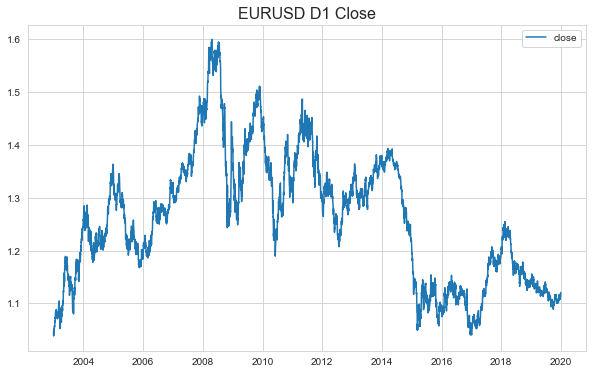

In [4]:
plt.figure(figsize=(10,6))

plt.plot(df_d1['close'], label='close')

plt.title(label = 'EURUSD D1 Close', fontsize=16)
plt.legend()

### Define Target (Label, Resutls) for supervised learning

In [5]:
df_d1.head()

,open,high,low,close
date,,,,
2003-01-01,1.0504,1.0504,1.0468,1.0476
2003-01-02,1.0475,1.0488,1.0338,1.0384
2003-01-03,1.0383,1.0437,1.0342,1.0423
2003-01-05,1.0420,1.0451,1.0418,1.0448
2003-01-06,1.0447,1.0496,1.0425,1.0440


In [6]:
look_ahead_7d_all_price_lvl = []

for row in range (len(df_d1.index)):
    row_close = df_d1.iloc[row][3]
    for i in range (1,8):
        try:
            look_ahead_7d_all_price_lvl.append(df_d1.iloc[row+i][1] - row_close)
            look_ahead_7d_all_price_lvl.append(df_d1.iloc[row+i][2] - row_close)
            look_ahead_7d_all_price_lvl.append(df_d1.iloc[row+i][3] - row_close)
        except:
            pass

In [7]:
len(look_ahead_7d_all_price_lvl)

111363

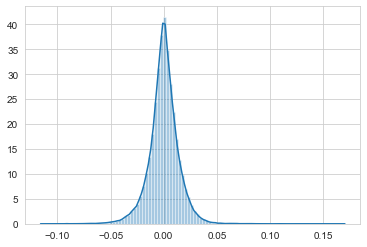

In [8]:
sns.distplot(look_ahead_7d_all_price_lvl, bins=100, kde=True)

In [9]:
print(f"Mean: {round(np.mean(look_ahead_7d_all_price_lvl),5)}")
print(f"sigma: {round(np.std(look_ahead_7d_all_price_lvl),5)}")

Mean: 1e-05
sigma: 0.01394


In [10]:
look_ahead_7d = {}

for row in range (len(df_d1.index)):
    row_close = df_d1.iloc[row][3]
    
    price_samp_7d_hi = []
    price_samp_7d_lo = []
    for i in range (1,8):
        try:
            price_samp_7d_hi.append(df_d1.iloc[row+i][1] - row_close)
            price_samp_7d_lo.append(df_d1.iloc[row+i][2] - row_close)
        except:
            pass
    
    try:
        look_ahead_7d[df_d1.iloc[row].name] = {}
        look_ahead_7d[df_d1.iloc[row].name]['price_list_hi'] = price_samp_7d_hi
        look_ahead_7d[df_d1.iloc[row].name]['price_list_lo'] = price_samp_7d_lo
    except:
            pass    

In [13]:
del_index=[]

for date in look_ahead_7d:
    if len(look_ahead_7d[date]['price_list_hi']) != 7:
        del_index.append(date)
        print(date, len(look_ahead_7d[date]['price_list_hi']))
        print(date, len(look_ahead_7d[date]['price_list_lo']))


In [12]:
for date in del_index:
    del look_ahead_7d[date]

# 3 Classes

In [14]:
threshold = 0.0140

for date in look_ahead_7d:
    for i in range (7):
        if look_ahead_7d[date]['price_list_lo'][i] > -0.33*threshold and look_ahead_7d[date]['price_list_hi'][i] > threshold:
            look_ahead_7d[date]['results'] = 1
            break
        elif look_ahead_7d[date]['price_list_hi'][i] < 0.33*threshold and look_ahead_7d[date]['price_list_lo'][i] < -1*threshold:
            look_ahead_7d[date]['results'] = 2
            break
        else:
            look_ahead_7d[date]['results'] = 0

In [15]:
results = pd.DataFrame(look_ahead_7d)
results = results.T
results.drop(['price_list_hi', 'price_list_lo'], axis=1, inplace=True)

In [16]:
results.head()

,results
2003-01-01,0
2003-01-02,1
2003-01-03,1
2003-01-05,1
2003-01-06,1


In [17]:
results['results'].value_counts(normalize=True)

1    0.368491
2    0.329623
0    0.301887
Name: results, dtype: float64

In [18]:
df_d1.shape

(5307, 4)

In [19]:
results.shape

(5300, 1)

In [20]:
df_d1_merge = pd.concat([df_d1, results], axis=1)
df_d1_merge.dropna(inplace=True)

In [21]:
df_d1_merge.head()

,open,high,low,close,results
2003-01-01,1.0504,1.0504,1.0468,1.0476,0
2003-01-02,1.0475,1.0488,1.0338,1.0384,1
2003-01-03,1.0383,1.0437,1.0342,1.0423,1
2003-01-05,1.0420,1.0451,1.0418,1.0448,1
2003-01-06,1.0447,1.0496,1.0425,1.0440,1


In [22]:
df_d1_merge.tail()

,open,high,low,close,results
2019-12-18,1.11312,1.11426,1.11105,1.11257,0
2019-12-19,1.11256,1.11442,1.11072,1.11157,0
2019-12-20,1.11156,1.11236,1.10662,1.10769,0
2019-12-22,1.10810,1.10830,1.10730,1.10783,1
2019-12-23,1.10783,1.10958,1.10699,1.10881,1


In [23]:
df_d1_merge.shape

(5300, 5)

In [24]:
df_d1_merge.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5300 entries, 2003-01-01 to 2019-12-23
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   open     5300 non-null   float64
 1   high     5300 non-null   float64
 2   low      5300 non-null   float64
 3   close    5300 non-null   float64
 4   results  5300 non-null   object 
dtypes: float64(4), object(1)
memory usage: 248.4+ KB


In [25]:
df_d1_merge.to_csv('../data/df_d1_merge.csv', index=True)